Importing RcTorch
-----------------

This is a barebones example RcTorch notebook. In this notebook we use hyper-parameters initially which are sub-optimal and get poor predictions. Both the pure prediction and parameter aware RC predictions are poor.

Installation: To install rctorch use the following command: `pip install rctorch`



Documentation: The RcTorch is hosted by readthedocs at the following link:





In [1]:
#pip install -U rctorch  # '-U' means update to latest version

In [2]:
#!pip install rctorch

In [3]:
cd /Users/hayden/Desktop/RcTorch/RcTorch

/Users/hayden/Desktop/RcTorch/RcTorch


In [4]:
#import packages
from rctorch import *
import torch
from rctorch.data import final_figure_plot as phase_plot

from matplotlib.pyplot import cm
from matplotlib import cm
import matplotlib.pyplot as plt

In [5]:
#housekeeping
plt.rcParams.update({
    "text.usetex": True})

plt.rcParams.update({'font.size': 22})

#
plotting_args = {'ylabel_pred' : r'$x$, $p$'}

### Load the data

0.5 7.3890560989306495
0.5 2.718281828459045
0.5 0.38674102345450123
0.5 0.36787944117144233
0.5 0.1353352832366127


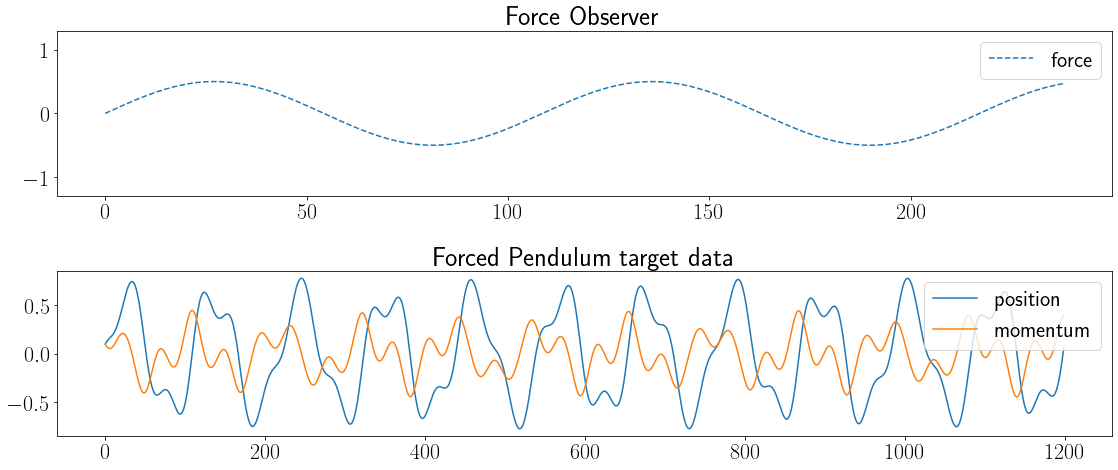

In [6]:
fp_data = data.load("forced_pendulum", train_proportion = 0.2, dt = np.pi/20)

force_train, force_test = fp_data["force"]
target_train, target_test = fp_data["target"]

### Define the HPs

In [7]:
hps = {'n_nodes' : 202,
       'log_connectivity' : 0.4071449746896983,
       'spectral_radius' : 1.1329107284545898,
       'regularization' : 1.6862021450927922,
       'leaking_rate' : 0.009808523580431938,
       'bias' : 0.48509588837623596}

### Fitting a Pure Prediction RC

mse 2.253
CPU times: user 752 ms, sys: 632 ms, total: 1.38 s
Wall time: 382 ms


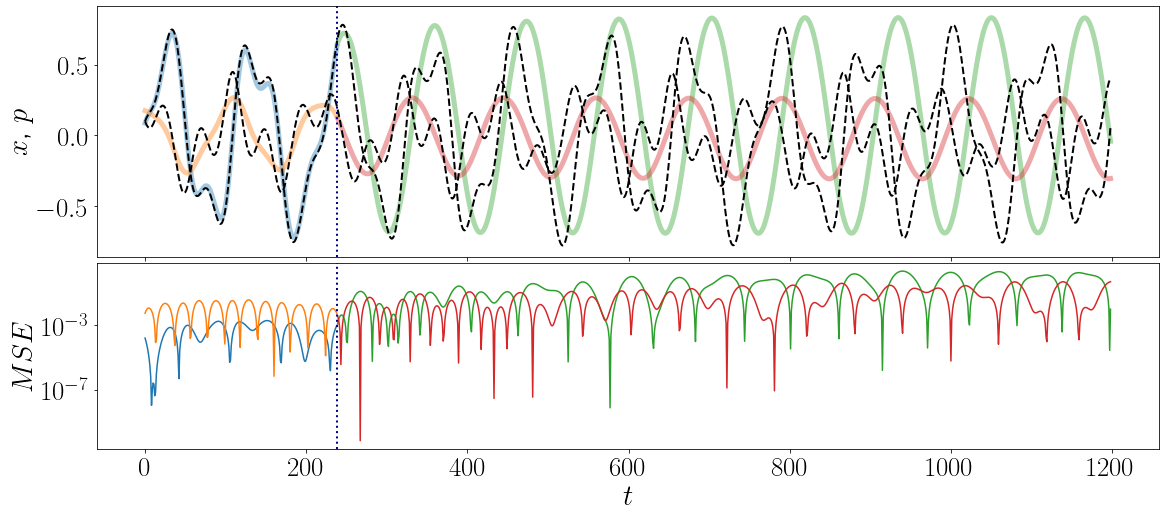

In [8]:
%%time
#set up the RC object
my_rc = RcNetwork(**hps, random_state = 210, feedback = True)

#fit the rc to the data:
my_rc.fit(y = target_train)

#make a pure prediction (no X)
score, prediction = my_rc.test(y = target_test)
print(f"mse {score:.3f}")
                               
my_rc.combined_plot(**plotting_args)

### Fitting a parameter aware RC

mse 0.229
CPU times: user 1.27 s, sys: 644 ms, total: 1.91 s
Wall time: 519 ms


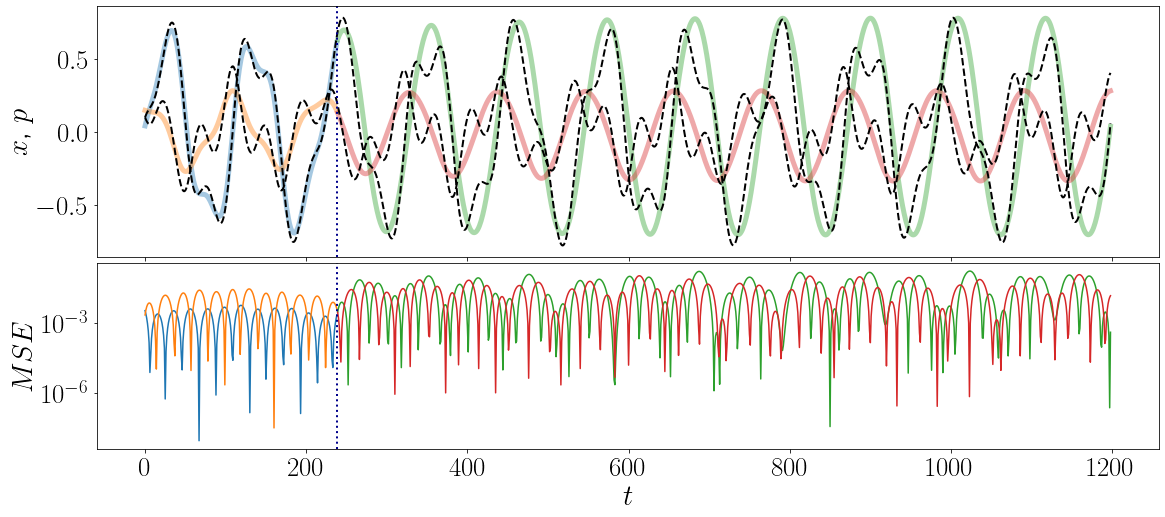

In [9]:
%%time
#set up the RC object 
my_rc2 = RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")

#plotting the prediction (trajectories on top where x is the position and p is the momentum)
my_rc2.combined_plot(**plotting_args)

### Making the phase space plots

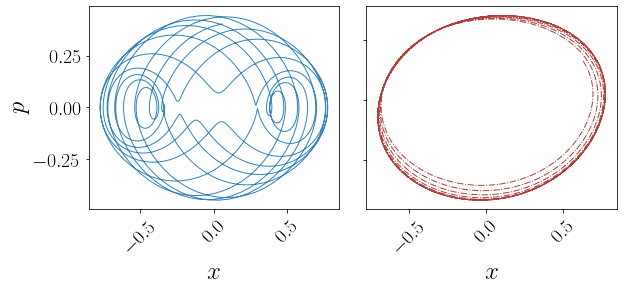

In [10]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}


phase_plot(target_test, None, prediction, 
                  **colors, 
                  label_fontsize = 25,
                  figsize = (9, 4.5)
                 )#, tick_fontsize = 22)

### Running a new Bayesian Optimization (BO) to find new hps

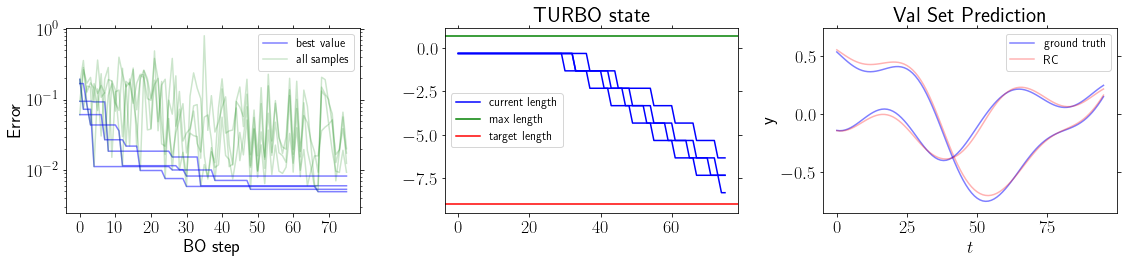

/Users/hayden/miniforge3/envs/arm/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitt

warning, matrix found that was not positive definite, returning best hyper-parameters found to this point


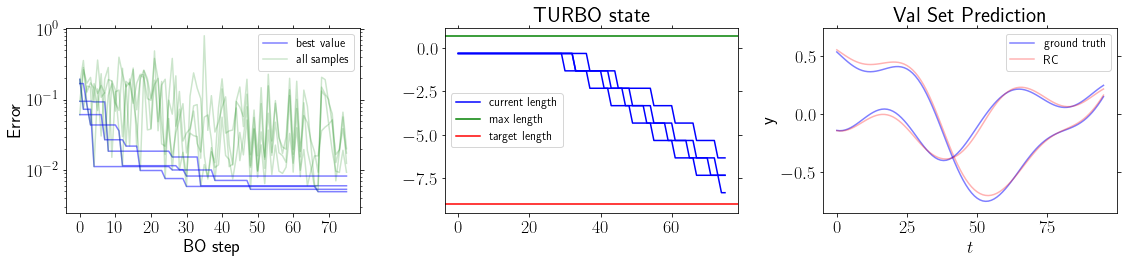

In [11]:
#any hyper parameter can have 'log_' in front of it's name. RcTorch will interpret this properly. 
bounds_dict = {"log_connectivity" : (-2.5, -0.1), 
               "spectral_radius" : (0.1, 3),
               "n_nodes" : (200,202),
               "log_regularization" : (-3, 1),
               "leaking_rate" : (0, 0.2),
               "bias": (-1,1)
               }

rc_specs = { "feedback" : True,
             "reservoir_weight_dist" : "uniform",
             "output_activation" : "tanh",
             "random_seed" : 209}

rc_bo = RcBayesOpt( bounds = bounds_dict, 
                    scoring_method = "nmse",
                    n_jobs = 4,
                    cv_samples = 1,
                    initial_samples = 25,
                    **rc_specs
                    )
opt_hps = rc_bo.optimize( n_trust_regions = 4, 
                                  max_evals = 500,
                                  x = force_train, 
                                  scoring_method = "nmse",
                                  y = target_train)

### Prediction trajectory plot

mse 0.010
CPU times: user 319 ms, sys: 357 ms, total: 676 ms
Wall time: 175 ms


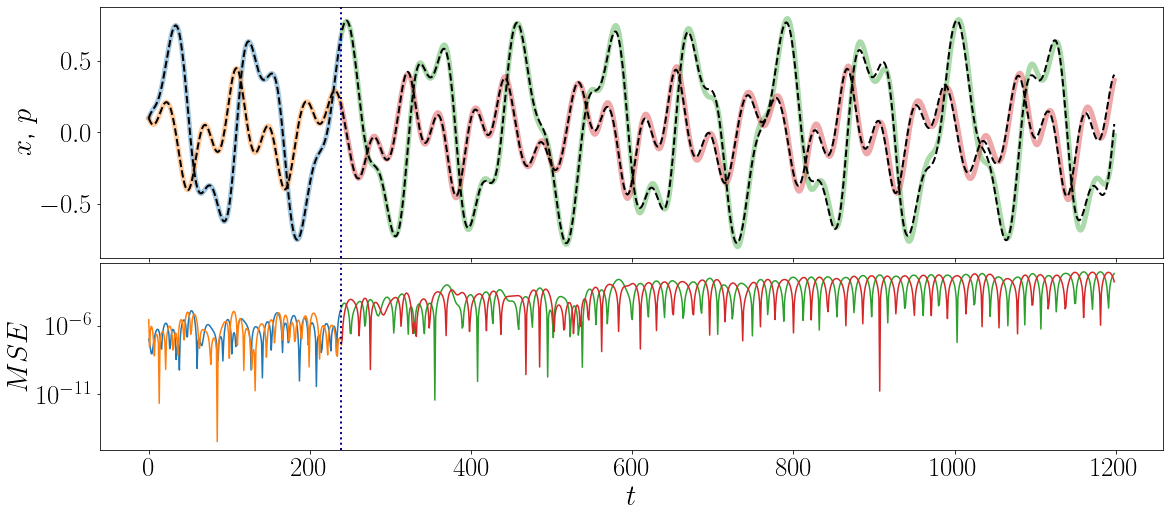

In [12]:
%%time
my_rc2 = RcNetwork(**opt_hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")
my_rc2.combined_plot(**plotting_args)

### Phase space plots

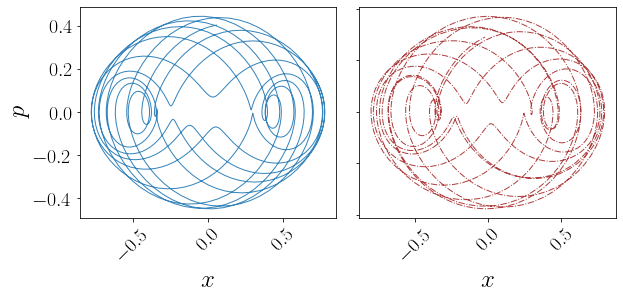

In [13]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}

phase_plot(test_gt = target_test,
           noisy_test_gt = None, 
           rc_pred = prediction, 
           **colors, 
           label_fontsize = 25,
           figsize = (9, 4.5)
           )